In [1]:
from paths import DATA_DIR, CKPT_FOLDER

import matplotlib.pyplot as plt
import numpy as np
import torch
import scanpy as sc
import scvelo as scv

import anndata
import pandas as pd

from torchdyn.core import NeuralODE

from scCFM.datamodules.time_sc_datamodule import TrajectoryDataModule
from scCFM.models.cfm.components.mlp import MLP
from scCFM.models.cfm.cfm_module import CFMLitModule

from notebooks.utils import (real_reconstructed_cells_adata,
                             add_velocity_to_adata, 
                             compute_velocity_projection, 
                             compute_trajectory, 
                             decode_trajectory)
from scipy.sparse import csr_matrix

from scib_metrics.benchmark import Benchmarker, BatchCorrection

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

**Read the anndata files**

In [3]:
adata_latent_vae = sc.read_h5ad(DATA_DIR / "eb" / "flat" / "eb_lib.h5ad")
# adata_latent_flat = sc.read_h5ad(DATA_DIR / "eb" / "flat" / "eb_flat_lib.h5ad")

In [4]:
adata_latent_vae.layers["X_latents"] = csr_matrix(adata_latent_vae.X.copy())
# adata_latent_flat.layers["X_latents"] = csr_matrix(adata_latent_flat.X.copy())

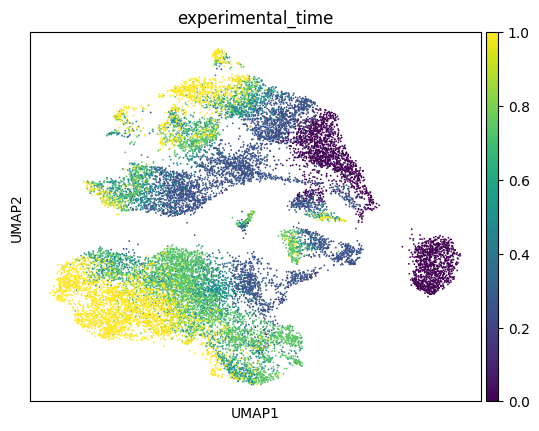

In [5]:
sc.pl.umap(adata_latent_vae, color="experimental_time")

In [6]:
# sc.pl.umap(adata_latent_flat, color="experimental_time")

Initialize datamodule

In [7]:
datamodule_kwargs_vae = {'path': '/nfs/homedirs/pala/scCFM/project_dir/data/eb/flat/eb_lib.h5ad',
                          'x_layer': 'X_latents',
                          'time_key': 'experimental_time', 
                          'use_pca': False, 
                          'n_dimensions': None, 
                          'train_val_test_split': [0.9, 0.1], 
                          'num_workers': 2, 
                          'batch_size': 512, 
                          'model_library_size': True}

datamodule_kwargs_flat = {'path': '/nfs/homedirs/pala/scCFM/project_dir/data/eb/flat/eb_flat_lib.h5ad',
                          'x_layer': 'X_latents',
                          'time_key': 'experimental_time', 
                          'use_pca': False, 
                          'n_dimensions': None, 
                          'train_val_test_split': [0.9, 0.1], 
                          'num_workers': 2, 
                          'batch_size': 512, 
                           'model_library_size': True}

# Initialize the datamodules 
datamodule_vae = TrajectoryDataModule(**datamodule_kwargs_vae)
# datamodule_flat = TrajectoryDataModule(**datamodule_kwargs_flat)

# Mapping real times to index
idx2time = datamodule_vae.idx2time

Velocity field network

In [8]:
net_hparams = {"dim": datamodule_vae.dim,
                "w": 64,
                "time_varying": True}

net_vae = MLP(**net_hparams).to(device)
# net_flat = MLP(**net_hparams).to(device)

CFM model 

In [9]:
cfm_kwargs = {'ot_sampler': 'exact', 
                   'sigma': 0.1, 
                   'use_real_time': False, 
                   'lr': 0.001, 
                   'antithetic_time_sampling': True}

cfm_vae = CFMLitModule(net=net_vae, datamodule=datamodule_vae, **cfm_kwargs).to(device)
# cfm_flat = CFMLitModule(net=net_flat, datamodule=datamodule_flat, **cfm_kwargs).to(device)

In [10]:
cfm_vae.load_state_dict(torch.load(CKPT_FOLDER / "trajectory" / "eb" / "best_cfm_model_eb.ckpt")["state_dict"])
# cfm_flat.load_state_dict(torch.load(CKPT_FOLDER / "trajectory" / "eb" / "best_cfm_model_flat_eb.ckpt")["state_dict"])

<All keys matched successfully>

**Plot the velocities**

In [11]:
add_velocity_to_adata(adata_latent_vae, cfm_vae, device)
# add_velocity_to_adata(adata_latent_flat, cfm_flat, device)

Non geometric

  0%|          | 0/18176 [00:00<?, ?cell/s]

  0%|          | 0/18176 [00:00<?, ?cell/s]

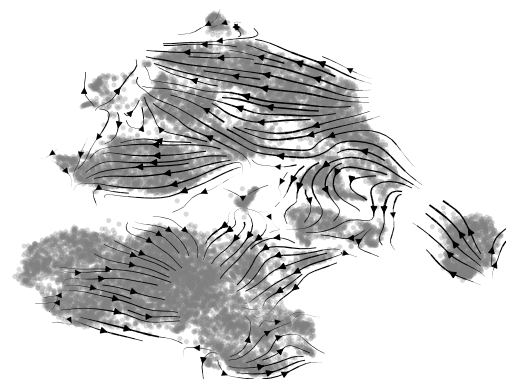

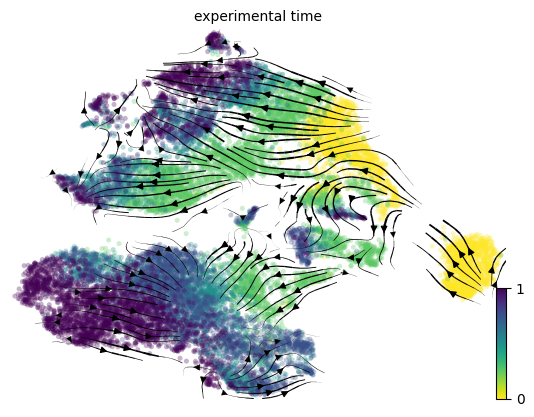

In [12]:
vk_vae_umap = compute_velocity_projection(adata_latent_vae, "X_latents", "velocity", "umap")
vk_vae_umap.compute_transition_matrix().plot_projection()
scv.pl.velocity_embedding_stream(adata_latent_vae, vkey="T_fwd", basis="umap", color="experimental_time")

  0%|          | 0/18176 [00:00<?, ?cell/s]

  0%|          | 0/18176 [00:00<?, ?cell/s]

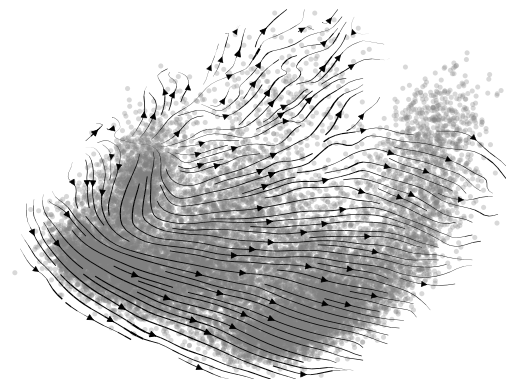

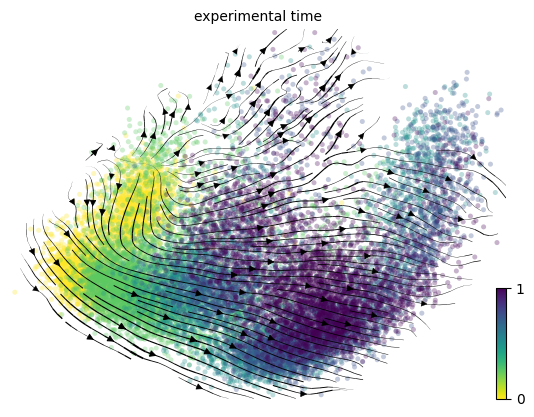

In [13]:
vk_vae_pca = compute_velocity_projection(adata_latent_vae, "X_latents", "velocity", "pca")
vk_vae_pca.compute_transition_matrix().plot_projection(basis="pca")
scv.pl.velocity_embedding_stream(adata_latent_vae, vkey="T_fwd", basis="pca", color="experimental_time")

Geometric

In [17]:
# vk_flat_umap = compute_velocity_projection(adata_latent_flat, "X_latents", "velocity", "umap")
# vk_flat_umap.compute_transition_matrix().plot_projection(basis="umap")
# scv.pl.velocity_embedding_stream(adata_latent_flat, vkey="T_fwd", basis="umap", color="experimental_time")

In [18]:
# vk_flat_pca = compute_velocity_projection(adata_latent_flat, "X_latents", "velocity", "umap")
# vk_flat_pca.compute_transition_matrix().plot_projection(basis="pca")
# scv.pl.velocity_embedding_stream(adata_latent_flat, vkey="T_fwd", basis="pca", color="experimental_time")

**Initialize and run kernel**

In [14]:
import cellrank as cr
from cellrank.estimators import CFLARE, GPCCA

Start from normal VAE data

In [20]:
vk_vae = cr.kernels.VelocityKernel(adata_latent_vae, 
                                   xkey="X_latents", 
                                   vkey="velocity")

In [21]:
vk_vae.compute_transition_matrix()

  0%|          | 0/18176 [00:00<?, ?cell/s]

  0%|          | 0/18176 [00:00<?, ?cell/s]

VelocityKernel[n=18176, model='deterministic', similarity='correlation', softmax_scale=4.457]

In [22]:
g = GPCCA(vk_vae)
print(g)

GPCCA[kernel=VelocityKernel[n=18176], initial_states=None, terminal_states=None]


In [ ]:
# g.fit(cluster_key="leiden")
g.compute_macrostates(n_states=4)

In [ ]:
adata_latent_vae